In [78]:
import sys
sys.path.append('..')

import canopus
import bqskit
from bqskit import Circuit
from bqskit import MachineModel
from qiskit.transpiler import CouplingMap
from bqskit.ir.gates import *
import pytket.qasm
from bqskit.ext.qiskit import qiskit_to_bqskit, bqskit_to_qiskit
from bqskit.ext.pytket import pytket_to_bqskit, bqskit_to_pytket
from math import pi
from qiskit import qasm2
import numpy as np

import warnings

# 抑制 NumPy 中行列式计算的警告
warnings.filterwarnings("ignore", message="divide by zero encountered in det")
warnings.filterwarnings("ignore", message="invalid value encountered in det")


In [27]:
fname = './output/logical/tk2/qft_n18.qasm'

circ = pytket.qasm.circuit_from_qasm(fname)
qc = canopus.utils.tket_to_qiskit(circ)
# circ = qiskit_to_bqskit(qc)
circ = pytket_to_bqskit(circ)


qc = qasm2.loads("""
OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
h q[0];
h q[2];
h q[5];
z q[0];
cx q[1],q[2];
cx q[4],q[5];
cx q[0],q[1];
cx q[2],q[3];
h q[2];
h q[3];
cx q[1],q[2];
cx q[3],q[5];
z q[3];
cx q[3],q[4];
cx q[0],q[3];
""")
circ = qiskit_to_bqskit(qc)

In [ ]:
qc.draw()

In [28]:
circ.gate_counts

{HGate: 5, CNOTGate: 8, ZGate: 2}

In [66]:
edge_list = list(canopus.utils.gene_chain_coupling_map(circ.num_qudits).graph.to_undirected().edge_list())

gate_set = {FixedCanonicalGate(pi/6, 0, 0), FixedCanonicalGate(pi/4, 0, 0), FixedCanonicalGate(pi/2, 0, 0), U3Gate()}
# gate_set = {FixedCanonicalGate(pi/4, pi/4, 0), U3Gate()}
# gate_set = {FixedCanonicalGate(pi/4, pi/4, 0), FixedCanonicalGate(pi/2, pi/4, pi/4), U3Gate()}
gate_set = {FixedCanonicalGate(pi/6, 0, 0), FixedCanonicalGate(pi/4, 0, 0), FixedCanonicalGate(pi/4, pi/4, 0), U3Gate()}

model = bqskit.MachineModel(circ.num_qudits, coupling_graph=edge_list, gate_set=gate_set)


In [67]:
circ_opt = bqskit.compile(circ, model=model)

In [68]:
circ_opt.gate_counts

{Can(0.25π,0.25π,0.00π): 12, Can(0.25π,0.00π,0.00π): 12, U3Gate: 65}

In [ ]:
canopus.utils.get_het_isa_coverage

In [100]:
def bqskit_result_depth(qc):
    qubit_indices = {qarg: q for q, qarg in enumerate(qc.qubits)}
    wire_durations = {q: 0.0 for q in range(qc.num_qubits)}
    for instr in qc.data:
        if instr.operation.num_qubits == 1:
            continue

        assert instr.operation.name == 'can'

        if np.allclose(instr.operation.params, [pi/6, 0, 0]):
            gate_duration = 1/3
        elif np.allclose(instr.operation.params, [pi/4, 0, 0]):
            gate_duration = 1/2
        elif np.allclose(instr.operation.params, [pi/4, pi/4, 0]):
            gate_duration = 0.75
        else:
            raise ValueError(f"Unsupported gate parameters: {instr.operation.params}")

        q0, q1 = qubit_indices[instr.qubits[0]], qubit_indices[instr.qubits[1]]
        
        current_duration = max(wire_durations[q0], wire_durations[q1]) + gate_duration
        wire_durations[q0] = current_duration
        wire_durations[q1] = current_duration

    return max(wire_durations.values())



def depth_calc_by_canopus(qc):
    qc = canopus.rebase_to_canonical(qc)
    return canopus.SynthCostEstimator('het').eval_circuit_cost(qc)

In [101]:
qc.data[0].qubits

(Qubit(QuantumRegister(6, 'q'), 0),)

In [102]:
qc_opt = bqskit_to_qiskit(circ_opt)
canopus.utils.remove_1q_gates(qc_opt).draw(fold=10000)


┌─────────────────┐┌─────────────────┐                                      ┌─────────────────┐┌─────────────────┐                                                                                                                                                
q_0: ──────────────────────────────────┤0                ├┤0                ├──────────────────────────────────────┤0                ├┤0                ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌───────────────┐┌───────────────┐│  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) │┌─────────────────┐┌─────────────────┐│  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) │                                                                                                              ┌───────────────┐┌───────────────┐
q_1: ┤0              ├┤0              ├┤1                ├┤1                ├┤0                ├┤0                ├┤1                ├┤1                ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0              ├┤0              ├
     │  Can(π/4,0,0) ││  Can(π/4,0,0) │└┬───────────────┬┘└┬───────────────┬┘│  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) │└─────────────────┘└─────────────────┘                                                     ┌─────────────────┐┌─────────────────┐┌─────────────────┐│  Can(π/4,0,0) ││  Can(π/4,0,0) │
q_2: ┤1              ├┤1              ├─┤0              ├──┤0              ├─┤1                ├┤1                ├───────────────────────────────────────────────────────────────────────────────────────────┤0                ├┤0                ├┤0                ├┤1              ├┤1              ├
     └───────────────┘└───────────────┘ │  Can(π/4,0,0) │  │  Can(π/4,0,0) │ └┬───────────────┬┘└┬───────────────┬┘                                                         ┌───────────────┐┌───────────────┐│  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) │└───────────────┘└───────────────┘
q_3: ───────────────────────────────────┤1              ├──┤1              ├──┤0              ├──┤0              ├──────────────────────────────────────────────────────────┤0              ├┤0              ├┤1                ├┤1                ├┤1                ├──────────────────────────────────
     ┌───────────────┐┌───────────────┐ └───────────────┘  └───────────────┘  │  Can(π/4,0,0) │  │  Can(π/4,0,0) │ ┌─────────────────┐┌─────────────────┐┌─────────────────┐│  Can(π/4,0,0) ││  Can(π/4,0,0) │└─────────────────┘└─────────────────┘└─────────────────┘                                  
q_4: ┤1              ├┤1              ├───────────────────────────────────────┤1              ├──┤1              ├─┤1                ├┤1                ├┤1                ├┤1              ├┤1              ├───────────────────────────────────────────────────────────────────────────────────────────
     │  Can(π/4,0,0) ││  Can(π/4,0,0) │                                       └───────────────┘  └───────────────┘ │  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) ││  Can(π/4,π/4,0) │└───────────────┘└───────────────┘                                                                                           
q_5: ┤0              ├┤0              ├────────────────────────────────────────────────────────────────────────────┤0                ├┤0                ├┤0                ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     └───────────────┘└───────────────┘                                                                            └─────────────────┘└─────────────────┘└─────────────────┘

In [103]:
depth_calc_by_canopus(qc_opt)

9.5

In [104]:
bqskit_result_depth(qc_opt)

9.5

In [98]:
FixedCanonicalGate(pi/2, 0, 0).angles

(1.5707963267948966, 0, 0)

In [99]:
0.7853981633974483 / (pi/2)

0.5

In [1]:
qc.data

NameError: name 'qc' is not defined

┌─────────────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ┌───────────────┐┌────────────────────────┐┌───────────────┐┌──────────────────────────┐
 q_0: ┤ U3(5.3522,1.6046,-0.047301) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [11]:
!ls ../benchmarks/medium/

bigadder_n18.qasm   knn_n25.qasm        qpeexact_16.qasm    wstate_n27.qasm
bv_n19.qasm         multiplier_n15.qasm qram_n20.qasm
gcm_n13.qasm        qec9xz_n17.qasm     sat_n11.qasm
ising_n26.qasm      qft_n18.qasm        swap_test_n25.qasm


In [13]:
circ = Circuit.from_file('../benchmarks/medium/wstate_n27.qasm')

In [34]:
# coupling_graph = [
#     (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7),
#     (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15),
#     (0, 8),
# ]
coupling_graph = list(canopus.utils.gene_chain_coupling_map(circ.num_qudits).get_edges())
gate_set = {CZGate(), RZGate(), SXGate()} 
model = MachineModel(circ.num_qudits, coupling_graph=coupling_graph)
out_circuit = bqskit.compile(circ, model=model)
print("Gate Counts:", out_circuit.gate_counts)
print("Connectivity:", out_circuit.coupling_graph)

/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid va

Gate Counts: {U3Gate: 175, CNOTGate: 52}
Connectivity: CouplingGraph({(3, 4), (21, 22), (12, 13), (22, 23), (8, 9), (17, 18), (25, 26), (13, 14), (18, 19), (4, 5), (5, 6), (14, 15), (23, 24), (9, 10), (0, 1), (10, 11), (1, 2), (19, 20), (24, 25), (15, 16), (6, 7), (20, 21), (11, 12), (2, 3), (7, 8), (16, 17)})


In [35]:
out_circuit.gate_counts

{U3Gate: 175, CNOTGate: 52}

In [31]:
list(CouplingMap(circ.coupling_graph).graph.to_undirected().edge_list())

[(3, 4),
 (21, 22),
 (12, 13),
 (22, 23),
 (8, 9),
 (17, 18),
 (25, 26),
 (13, 14),
 (18, 19),
 (4, 5),
 (5, 6),
 (14, 15),
 (23, 24),
 (9, 10),
 (0, 1),
 (10, 11),
 (1, 2),
 (19, 20),
 (24, 25),
 (15, 16),
 (6, 7),
 (20, 21),
 (11, 12),
 (2, 3),
 (7, 8),
 (16, 17)]

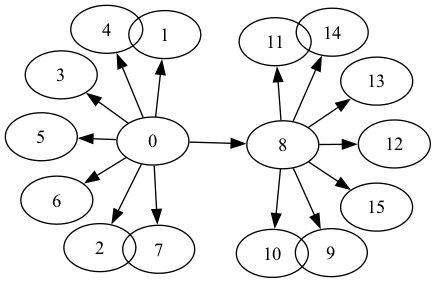

In [6]:
CouplingMap([
    (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7),
    (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15),
    (0, 8),
]).draw()

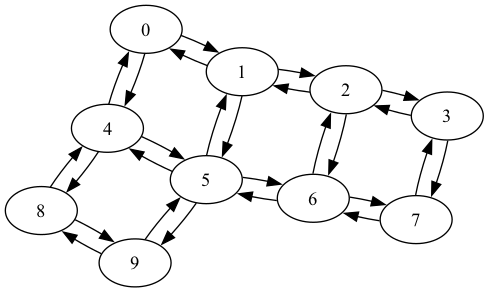

In [ ]:
canopus.utils.gene_square_coupling_map(10).graph.